In [1]:
### Classify using complaint using doc2vec

https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

data set is at  https://catalog.data.gov/dataset/consumer-complaint-database

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Consumer_Complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.head(10)

,narrative,Product
457,I changed adress and was never sent any notice...,Debt collection
477,XXXX XXXX is reporting a account on all three ...,Debt collection
501,XXXX XXXX/XXXX XXXX is listed on my Experian ...,"Credit reporting, credit repair services, or o..."
507,XXXX XXXX XXXX listed multiple 30/60/90/120/15...,"Credit reporting, credit repair services, or o..."
517,I pulled all 3 of my credit reports to find ou...,"Credit reporting, credit repair services, or o..."
527,To Whom It May Concern This is the third time ...,"Credit reporting, credit repair services, or o..."
528,XXXX listed multiple 30/60/90/120 day late pay...,"Credit reporting, credit repair services, or o..."
543,sent ftc violations and police report of havin...,"Credit reporting, credit repair services, or o..."
549,Credit bureaus are reporting these addresses o...,"Credit reporting, credit repair services, or o..."
558,Divorce decree assigned two accounts to my exw...,"Credit reporting, credit repair services, or o..."


In [4]:
df.shape

(58874, 2)

In [6]:
#df.index = range(318718)
df.index = range(58874)

In [7]:
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

11714107

We have over 63 million words, it is not a small data set.

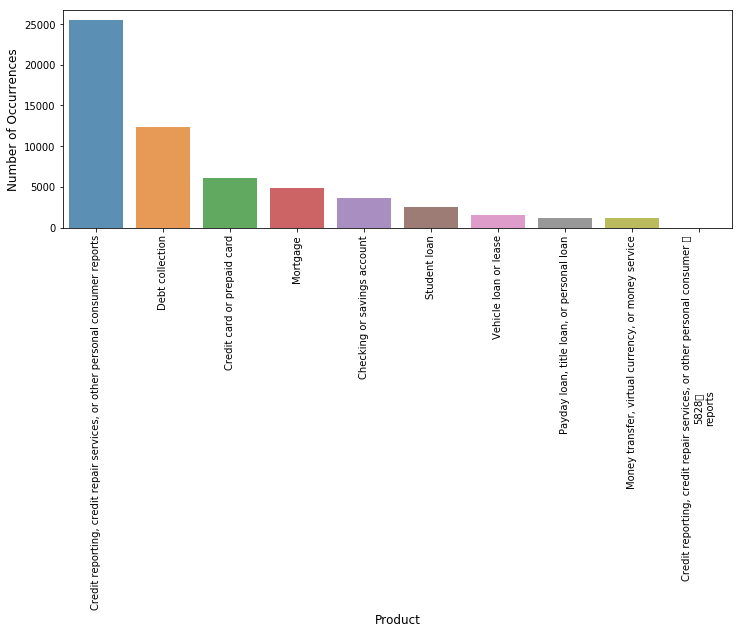

In [8]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

The classes are imbalanced. However, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

Let's have a look a few examples of complaint narrative and its associated product.

In [9]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [10]:
print_complaint(12)

XXXX XXXX XXXX # XXXX -each bureau reports a different date of last activity Date XXXX  ShowsXX/XX/XXXX Experian Shows XX/XX/XXXX XXXX  Shows XX/XX/XXXX Experian, XXXX, XXXX is showing a monthly payment as well as a past due on closed account of {$1000.00} how is this possible? ( THIS ACCOUNT NEEDS TO BE DELETED PLEASE ) This is how I know that it wasn't a proper investigation. FCRA is very clear about the law.
('Product:', 'Credit reporting, credit repair services, or other personal consumer reports')


In [11]:
print_complaint(20)

I would like to submit a complaint regarding the unfair and abusive fees assessed to make a payment on the debt owed. The company is charging a {$5.00} fee to make a payment via debit or credit card. This fee is also assessed if making the payment for a medical debt via a health savings account. The fee is unreasonable as it does not reflect the cost to process a single credit card transaction, is not a fee associated with making the payment over the phone or for an expedited payment, and it is much higher than other merchants charge. I was only provided with an alternative to avoid the fee after I questioned why it would cost {$5.00} to pay my debt. After I refused to pay via credit card and accept the fee, the representative indicated that I could also pay by check to avoid the fee. I could still make the payment by phone but needed to provide full bank account details. Additionally, I would like to note when I was first contacted by the debt collector I was pressured to make a payme

### Text preprocessing

Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [12]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

In [13]:
df['narrative'][20]

u'i would like to submit a complaint regarding the unfair and abusive fees assessed to make a payment on the debt owed. the company is charging a {$5.00} fee to make a payment via debit or credit card. this fee is also assessed if making the payment for a medical debt via a health savings account. the fee is unreasonable as it does not reflect the cost to process a single credit card transaction, is not a fee associated with making the payment over the phone or for an epedited payment, and it is much higher than other merchants charge. i was only provided with an alternative to avoid the fee after i questioned why it would cost {$5.00} to pay my debt. after i refused to pay via credit card and accept the fee, the representative indicated that i could also pay by check to avoid the fee. i could still make the payment by phone but needed to provide full bank account details. additionally, i would like to note when i was first contacted by the debt collector i was pressured to make a paym

Train/test split of 70/30.

In [14]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [15]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [16]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

This is what a training entry looks like - an example complaint narrative tagged by 'Credit reporting'.

In [17]:
train_tagged.values[30]

TaggedDocument(words=[u'referencing', u'the', u'attachment', u'on', u'pages', u'5,6,7', u'under', u'microscope', u'rushmore', u'unidentified', u'representatives', u'states', u'in', u'fact', u'that', u'eecuted', u'and', u'authorized', u'rushmore', u'as', u'power', u'of', u'attorney', u'as', u'its', u'servicer', u'attorney-in-fact', u'on', u'//2016'], tags=['Mortgage'])

## Training the model

We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

### DBOW

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

We set the minimum word count to 2 in order to discard words with very few occurrences. 

In [18]:
import multiprocessing

cores = multiprocessing.cpu_count()

Build a vocabulary

In [19]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 41211/41211 [00:00<00:00, 1502233.23it/s]


In [20]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 41211/41211 [00:00<00:00, 1503670.74it/s]


CPU times: user 9min 27s, sys: 24 s, total: 9min 51s
Wall time: 3min 33s


### Buliding the final vector feature for the classifier.

In [21]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [22]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [23]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [27]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6926909358546114
Testing F1 score: 0.686397737174


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Distributed Memory with Averaging

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.
We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [24]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 41211/41211 [00:00<00:00, 68601.43it/s]


In [25]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 41211/41211 [00:00<00:00, 1138956.55it/s]


CPU times: user 15min 27s, sys: 37.8 s, total: 16min 5s
Wall time: 6min 13s


### Train Logistic Regression

In [28]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6943894015739116
Testing F1 score: 0.687861434521


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [29]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [31]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [32]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [33]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [34]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6968804846288852
Testing F1 score: 0.691758321246


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
